---
## Import packages

In [84]:
# !pip install ar_wordcloud
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# !pip install art

In [85]:
from art import*
art= text2art ("Let 's     Go    !!!")
print(art)

 _            _     _             ____             _  _  _ 
| |      ___ | |_  ( ) ___       / ___|  ___      | || || |
| |     / _ \| __| |/ / __|     | |  _  / _ \     | || || |
| |___ |  __/| |_     \__ \     | |_| || (_) |    |_||_||_|
|_____| \___| \__|    |___/      \____| \___/     (_)(_)(_)
                                                           



In [86]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# %config InlineBackend.figure_format = 'svg'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from yellowbrick.cluster import KElbowVisualizer

import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import scipy.cluster.hierarchy as sch

import string
import time
import unicodedata as ud
import arabic_reshaper
import re
from ar_wordcloud import ArabicWordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans

import nltk
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer

## Read and exploring the data

In [7]:
df = pd.read_csv('/content/SaudiNews3k')
df.drop(columns= ['Unnamed: 0'], inplace= True)
df

,source,title,content
0,aljazirah,مدرب الأهلي يستبعد لاعبين جديدين من قائمته قبل...,جروس\nعلمت (الجزيرة) أن مدرب الأهلي كريستيان ...
1,alriyadh,تقرير: تراجع الإيرادات المباشرة لشركات الاتصال...,تراجع إجمالي الإيرادات المباشرة لشركات الا...
2,aleqtisadiya,أوباما يدعو بريطانيا للبقاء في الاتحاد الأوروبي,حث الرئيس الأمريكي باراك أوباما بريطانيا على ...
3,sabq,الغذامي يقتحم عالم الصحافة الإلكترونية بمقال أ...,عاصم الغامدي - سبق – جدة: انضم الكاتب والناقد...
4,aawsat,«إف بي آي»: توقيف رجل يقدم نفسه على «فيسبوك» ب...,أعلن مكتب التحقيقات الفدرالي (اف بي آي) مساء أ...
...,...,...,...
2995,alriyadh,الصحة: ثلاث إصابات بكورونا وشفاء حالة في الرياض,أعلنت وزارة الصحة اليوم الجمعة عن تسجيل ثل...
2996,alriyadh,السيسي: مصر والسعودية هما جناحا الأمن القومي ا...,بحضور فخامة الرئيس عبدالفتاح السيسي رئيس ج...
2997,aljazirah,تعليم القصيم يستقبل سفيرات الحزم,\nاستقبلت الإدارة العامة للتعليم بمنطقة القصيم...
2998,okaz,ركن السيارة.. مظهر حضاري غائب,المشهد المتصدر اليوم في الطرقات لدينا هو المط...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   source   3000 non-null   object
 1   title    2995 non-null   object
 2   content  2988 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB


In [9]:
df.duplicated().sum()

22

In [10]:
df.drop_duplicates(inplace = True)

In [11]:
# To display full text
pd.set_option('display.max_colwidth',-1)#can see the whole data on one single row
# complaints_df
df

source  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

## NLP Preprocessing

In [12]:
max(df.content.str.len())

21130.0

In [13]:
min(df.content.str.len())

1.0

**removing observtions less than 120**

In [14]:
df = df[df.content.str.len() > 120]

In [15]:
df.shape

(2918, 3)

In [16]:
df.content.isna().sum()

0

### **Removing Non-arabic letters, numbers, amiss typo and special characters**


In [17]:
# function to clean and normalize text 
def clean_text(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']  
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
        
    text = text.strip()
    
    return text

In [18]:
arabic_punctuations = '''«»`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    
    return text


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [19]:
# clean and normalize text
df.content  = df.content.apply(lambda x: clean_text(x))

# remove punctuation
df.content  = df.content.apply(lambda x: remove_punctuations(x))

# remove diacritics
df.content  = df.content.apply(lambda x: remove_diacritics(x))

# remove repeating char
df.content  = df.content.apply(lambda x: remove_repeating_char(x))

# remove english letters
df.content = df.content.apply(lambda x: re.sub(r'[a-zA-Z]', '', x))

# remove a special character 
df.content = df.content.apply(lambda x: re.sub(r'[_]+', '', x))

# remove english numbers
df.content = df.content.apply(lambda x: re.sub(r'/[0-9\u0621-\u064A]+/u', '', x))

# remove space
df.content  = df.content.str.replace('\d+', '')

In [20]:
# Convert to list
data = df[df.columns[2]].values.tolist()

### **Stemming**

In [21]:
stopـwords =nltk.corpus.stopwords.words("arabic")
stopـwords.extend(['هـ', 'د', 'م', 'الى', 'ان', 'اذ', 'لهذه',
                   'قال', 'وقال', 'اكد', 'عدد', 'بعدد', 'وعدد'
                   , 'والتي', 'بن', 'بنت', 'وقد', 'ا', 'عبر',
                   'خلال', 'او', 'الا', 'وان', 'اي', 'بان', 'كان'
                   , 'كانت' ,'تم','الف','مليون', 'وفي', 'وقد','اكثر','اقل'
                   , 'انه','وانه', 'قالت', 'وقالت', 'وتم','اذا', 'وسوف', 'ه', 'م', 'كثير',
                   'ودليل', 'معهم','مصدر'
                   ,'مر','على','تنتهي','كبيرة','تستمر','الفرج','وواضح','وصاحب',
                   'يتم','،وذلك','تكون','عليها'
                   ,'انها','امس','العامه','الثاني','لاداره','اكبر','الف','اليوم'
                   ,'خلال','الاسبوع','اباغسطس','اباطيلهم','ابارك','ابارا','ابار','اباده','اباحيا','اباتشي',
                   'ابابا','ابائهم','ابائه','اباؤهم','اباؤنا','اباؤكن','اباءهم','اباءنا','اباء','ابا'
                   ,'اب','ائمه','ائذن','ائتماني','ائتلافيه','ائتلافا','ئايه','اباحه','ابالخيل'
                   ,'ابالغ','ابان','ابانات','ابانها','اباه','اباوت',
                   'ابت','ابتد','ابتدا','ابتداء','ابتدائي',
                   'ابتدائيا','ابتدائيه','ابتدات','ابتدعها','ابتدعوا','ابتسام','ابتسامات','ابتسامتكم',
                   'ابتسامتها','ابتسامتهم','ابتسامه'
                   ,'ابتسم','ابتسمت'
                   ,'ابتعاثاهل','ابتعاثهم'
                   ,'ﺍﻟﻔﻴﻮﺵ','ﺍﻟﻤﺨﺘﻠﻔﺔ','ﺍﻟﻤﻨﺎﻃﻖ','ﺍﻟﻤﻄﺎﺭ','ﺍﻟﻤﻌﻨﻴﺔ','ﺑﺎﺏ','ﺑﻤﺮﻳﺲ',
                   'ﺣﺎﻟﻴﺎ','ﺣﺘﻰ','ﺩﺍﺭ','ﺳﺘﻮﺍﺻﻞ','ﻋﻤﻠﻴﺎﺗﻬﺎ'
                   ,'ﻓﻲ','ﻛﻞ','ﻟﻌﻮﺩﺓ','ﻣنطقه','ﻣﺠﺎﻝ','ﻣﻊ','ﻣﻦ','ﻭان','ﻭﺍﺳﺘﻘﺒﺎﻝ'
                   ,'ﻭﺍﻟﻜﺜﻴﺮ','ﻷي','ﻹكمال','ﻹنشائه','ﻭﻣﻌﺎﺭﻙ','ﻭﻣﺴﺘﻘﺮﺓ','ﻭﺍﻟﻤﻮﺍﻧﺊ','ﺇﻟﻰ','ائتمانيه'
                   ,'اؤمن','اؤدي','اؤكد','ابتعاده',
                   'ابتعادهم','ابتعث','ابتعثت','ابتعدت','ابتعدوا','ابتغي','ابتكارا',
                   'ابتكارات','ابتكاره','ابتكر','ابتكرها'
                   ,'ابتكروا','ابتلعت','ابتليت','ابجديتي'
                   ,'يونيوحزيران','يونيور','يونيون','يونيكريدت','يونيه','یعني','يويو','',
                   '','','','','','','','','','','','','','','','',
                   '','','','','','','','','','','','','','','','',
                   '','','','','','','','','','','','','','','','',
                   '','','','','','','','','','','','','','','','',
                   '','','','','','','','','','','','','','','','',
                   '','','','','','','','','','','','','','','','',
                   '','','','','','','','','','','','','','','','',
                   '','','','','','','','','','','','','','','','',
                   '','','','','','','','','','','','','','','','',])

In [22]:
#stemming as experiment
def apply_stemming_and_Stopwords(texts):
    st = ISRIStemmer()
    return [[st.stem(word) for word in simple_preprocess(str(doc)) if word not in stopـwords] for doc in texts]

In [23]:
stemmstop_word=apply_stemming_and_Stopwords(df.content)

In [25]:
#remove stopwords and all characters that are not arabic letters or # numbers and lemmatize the words
def preprocess_ar(text):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    st = ISRIStemmer()
    
    for t in text:
        t = ''.join(c for c in t if ud.category(c) == 'Lo' or ud.category(c) == 'Nd' or c == ' ')
        commentwords = ''
        for word in t.split():
            # Checking if the word is a stopword.
            if word not in stopـwords :
                if len(word)>1:
                    # Lemmatizing the word.
                    word = st.suf32(word)
                    commentwords += (word+' ')
    processedText.append(commentwords)
    
    return processedText

In [26]:
text_ar = list(df['content'])
processedtext_ar = preprocess_ar(text_ar)

### **TF-IDF Vectorizer**

In [24]:
# the document-term matrix 
tfidf = TfidfVectorizer(stop_words=stopـwords)
doc_words = tfidf.fit_transform(df.content)
pd.DataFrame(doc_words.toarray(),columns=tfidf.get_feature_names())

,ائتلاف,ائتمان,اباحي,اباد,ابتدعوه,ابتذال,ابتزاز,ابتعاث,ابتعاد,ابتعد,ابتغاء,ابتكار,ابتلاء,ابتلاع,ابتلي,ابتهاجا,ابتهالا,ابتياع,ابجديات,ابحاث,ابحاثا,ابحاثه,ابحاثهم,ابحار,ابحث,ابحثوا,ابحثي,ابحر,ابد,ابدا,ابداء,ابدار,ابداع,ابداعا,ابداعات,ابداعاته,ابداعاتهم,ابداعه,ابداعها,ابداعهم,...,يونايتد,يونج,يونس,يونغ,يونغبيون,يونكر,يونهاب,يونيسكو,يونيسيف,يونيكر,يوهان,يوهاندري,يوهانس,يوهمون,يوهندي,يوي,يويشي,يويفا,یشرف,یلقبه,ﺁﻣﻨﺔ,ﺍﺳﺘﻬﺪﻑ,ﺍﻟﺤﻮﺛﻲ,ﺍﻟﺤﻴﺎﺓ,ﺍﻟﺸﻌﺒﻴﺔ,ﺍﻟﺼﺪﺭﻳﻦ,ﺍﻟﻌﺎﻣﺔ,ﺍﻟﻌﺴﻜﺮﻳﺔ,ﺍﻟﻘﺎﺿﻲ,ﺍﻟﻤﺘﻤﺮﺩﻳﻦ,ﺍﻟﻤﻘﺎﻭﻣﺔ,ﺍﻟﻴﺎﻓﻌﻲ,ﺍﻟﻼﺯﻣﺔ,ﺍﻹﻏﺎﺛﺔ,ﻋﻨﻴﻔﺔ,ﻏﺎﺭﺍﺕ,ﻓﺮﺕ,ﻟﻠﺘﺤﺎﻟﻒ,ﻣﺤﺮﺭﺓ,ﻣﺴﺎﻋﺪﺍﺕ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## EDA

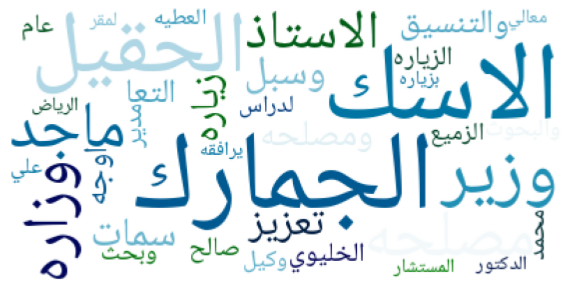

In [87]:
# print WordCloud visualization

awc = ArabicWordCloud(background_color="white")
plt.figure(figsize = (10,10))
wc_ar = awc.from_text(u''.join(processedtext_ar))
plt.imshow(wc_ar.recolor(colormap='ocean'))
plt.axis('off');
# plt.savefig('plot1.png', dpi = 300, bbox_inches = 'tight');

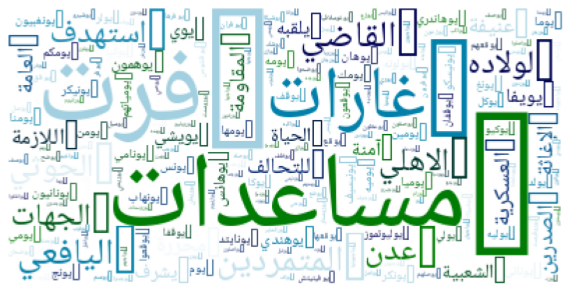

In [88]:
# print WordCloud visualization

awc = ArabicWordCloud(background_color="white")
plt.figure(figsize = (10,10))
a = tfidf.get_feature_names()
a1 = [elem.strip().split() for elem in a]
wordcloud = awc.generate(str(a1)).from_text(str(a1));
plt.imshow(wordcloud.recolor(colormap='ocean'));
plt.axis('off');
# plt.savefig('plot2.png', dpi = 300, bbox_inches = 'tight');

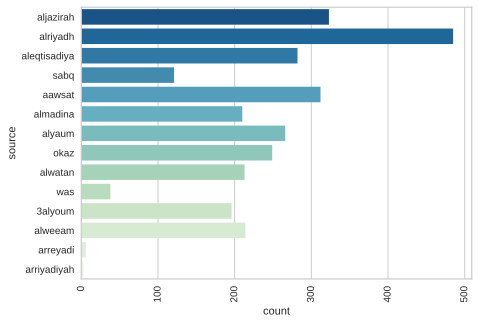

In [89]:
plt.figure(figsize=(7,5))
plt.xticks(rotation=90)
sns.countplot(y="source", data=df, palette='GnBu_r');
# plt.savefig('plot3.png', dpi = 300, bbox_inches = 'tight');

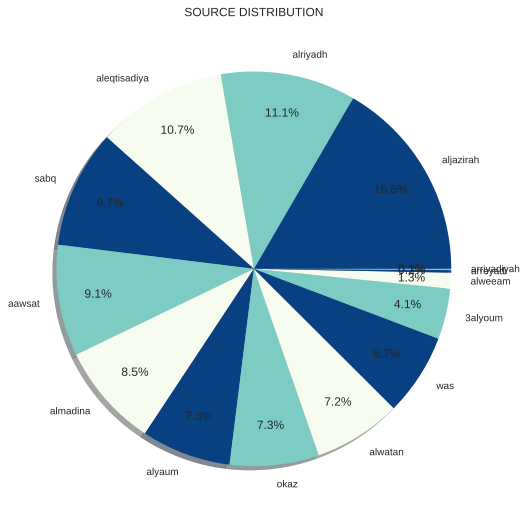

In [90]:
targetCounts = df['source'].value_counts()
targetLabels  = df['source'].unique()
# Make square figures and axes
plt.figure(1, figsize=(20,20))
the_grid = GridSpec(2, 2)

#Blues_r #PuBuGn #Sequential
cmap = plt.get_cmap('GnBu_r')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
plt.subplot(the_grid[0, 1], aspect=1, title='SOURCE DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, pctdistance=0.8, 
                     autopct='%1.1f%%', shadow=True, colors=colors )

# plt.savefig('plot4.png', dpi = 300, bbox_inches = 'tight');

## **Topic Modeling**


1. NMF

In [31]:
# function to display topics with words
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
#         else:
#             print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    

def display_top(model, feature_names, no_top_words, topic_names=None):
    
    my_dict = {'topic_0':'','topic_1':'','topic_2':'','topic_3':'','topic_4':''}
    ctr = 0
    for ix, topic in enumerate(model.components_):
                #if not topic_names or not topic_names[ix]:
#             print("\nTopic ", ix)
        txt = ",".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        my_dict['topic_'+str(ctr)] = txt
        ctr+=1
#         print('words are::: ',txt)
    return my_dict

In [32]:
topic_nums = list(np.arange(3, 10, 1))

#nmf_models = []
for num in topic_nums:
    nmf = NMF(num)
    #nmf_models.append(nmf)
    nmf.fit_transform(doc_words)
    display_topics(nmf, tfidf.get_feature_names(), 50)
    print("------------------------------------------")


Topic  0
علي, الي, ايران, العام, داعش, النفط, العمل, السعوديه, المائه, عام, المتحده, عدن, عد, الملكه, حتي, المنطقه, الماضي, الاتفاق, اسعار, مليار, وزاره, بنسبه, مدينه, المقاومه, المدينه, اخري, بشكل, منطقه, محافظه, شركه, السوق, تنظيم, البلديه, النظام, الحكومه, اليمن, الرئيس, الطاقه, العالم, وهي, وذلك, ضد, الدولي, الشركه, ايضا, الولايات, فان, الايراني, دول, احد

Topic  1
عبدالعزيز, الامير, اله, السمو, ولي, الملكي, الحرمين, الشريفين, خادم, سلمان, محمد, الملك, سعود, وزير, صاحب, العهد, عسير, الملكه, سموه, نائب, عبداله, ال, رئيس, فيصل, مجلس, الدكتور, خالد, منطقه, الوزراء, العربيه, نايف, الامن, الطوارئ, علي, امير, الدفاع, السعوديه, جمهوريه, الفيصل, الشهداء, الوطن, مكه, المكرمه, بمنطقه, فهد, مدير, سمو, جده, حفظه, الخاصه

Topic  2
الفريق, الاتحاد, النادي, علي, الاعب, الموسم, الاعبين, القدم, المدرب, نادي, السعودي, لكره, لاعب, فريق, الهلال, المعسكر, الي, المقبل, النصر, السوبر, الفني, كاس, الاهلي, اداره, المباراه, الاول, الاداره, الدوري, الانديه, امام, مباراه, الوديه, لفريق, مدرب, الشباب, سان, لا

In [33]:
nmf_model = NMF(8)
doc_topic = nmf_model.fit_transform(doc_words)

In [34]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"
             ,"component_6","component_7","component_8"],
             columns = tfidf.get_feature_names())
topic_word

,ائتلاف,ائتمان,اباحي,اباد,ابتدعوه,ابتذال,ابتزاز,ابتعاث,ابتعاد,ابتعد,ابتغاء,ابتكار,ابتلاء,ابتلاع,ابتلي,ابتهاجا,ابتهالا,ابتياع,ابجديات,ابحاث,ابحاثا,ابحاثه,ابحاثهم,ابحار,ابحث,ابحثوا,ابحثي,ابحر,ابد,ابدا,ابداء,ابدار,ابداع,ابداعا,ابداعات,ابداعاته,ابداعاتهم,ابداعه,ابداعها,ابداعهم,...,يونايتد,يونج,يونس,يونغ,يونغبيون,يونكر,يونهاب,يونيسكو,يونيسيف,يونيكر,يوهان,يوهاندري,يوهانس,يوهمون,يوهندي,يوي,يويشي,يويفا,یشرف,یلقبه,ﺁﻣﻨﺔ,ﺍﺳﺘﻬﺪﻑ,ﺍﻟﺤﻮﺛﻲ,ﺍﻟﺤﻴﺎﺓ,ﺍﻟﺸﻌﺒﻴﺔ,ﺍﻟﺼﺪﺭﻳﻦ,ﺍﻟﻌﺎﻣﺔ,ﺍﻟﻌﺴﻜﺮﻳﺔ,ﺍﻟﻘﺎﺿﻲ,ﺍﻟﻤﺘﻤﺮﺩﻳﻦ,ﺍﻟﻤﻘﺎﻭﻣﺔ,ﺍﻟﻴﺎﻓﻌﻲ,ﺍﻟﻼﺯﻣﺔ,ﺍﻹﻏﺎﺛﺔ,ﻋﻨﻴﻔﺔ,ﻏﺎﺭﺍﺕ,ﻓﺮﺕ,ﻟﻠﺘﺤﺎﻟﻒ,ﻣﺤﺮﺭﺓ,ﻣﺴﺎﻋﺪﺍﺕ
component_1,0.019,0.0,0.000,0.008,0.0,0.000,0.001,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.000,0.002,0.0,0.0,0.000,0.004,0.0,0.0,0.001,0.000,0.001,0.0,0.0,0.000,0.000,0.023,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.000,...,0.004,0.001,0.001,0.000,0.001,0.000,0.001,0.0,0.000,0.002,0.000,0.000,0.000,0.000,0.0,0.001,0.002,0.001,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_2,0.001,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.003,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.005,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_3,0.000,0.0,0.001,0.001,0.0,0.000,0.000,0.000,0.003,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.009,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.000,...,0.107,0.000,0.006,0.003,0.000,0.000,0.000,0.0,0.000,0.000,0.002,0.025,0.000,0.000,0.0,0.000,0.000,0.004,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_4,0.001,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.001,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.0,0.000,0.001,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_5,0.001,0.0,0.000,0.000,0.0,0.000,0.000,0.003,0.000,0.001,0.000,0.004,0.000,0.001,0.000,0.001,0.0,0.0,0.001,0.008,0.0,0.0,0.001,0.001,0.001,0.0,0.0,0.008,0.000,0.003,0.008,0.0,0.001,0.001,0.001,0.0,0.001,0.0,0.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.001,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_6,0.001,0.0,0.000,0.001,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.003,0.000,0.000,0.000,0.008,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.003,0.004,0.003,0.003,0.003,0.004,0.003,0.003,0.004,0.007,0.007,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003
component_7,0.000,0.0,0.002,0.004,0.0,0.001,0.000,0.000,0.000,0.001,0.001,0.000,0.001,0.000,0.002,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.001,0.0,0.0,0.000,0.002,0.021,0.001,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.001,...,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_8,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.002,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0

In [35]:
display_topics(nmf_model, tfidf.get_feature_names(), 50)



Topic  0
ايران, علي, داعش, الاتفاق, الي, النوي, تنظيم, المتحده, سوريا, الايراني, الخارجيه, تركيا, السوري, العراق, ضد, اوباما, الاسد, التركيه, النظام, الارهاب, السوريه, وزير, الولايات, حزب, التنظيم, كيري, المنطقه, دول, سوريه, الرئيس, الايرانيه, الجيش, واشنطن, مجلس, التركي, العراقيه, الدولي, العربيه, الامن, الكردستاني, الحكومه, الوزراء, التعاون, المعارضه, مصر, رئيس, الدول, العمال, الاميركي, القوات

Topic  1
الامير, عبدالعزيز, السمو, الملكي, ولي, الحرمين, الشريفين, خادم, سلمان, الملك, محمد, سعود, وزير, العهد, صاحب, الوزراء, رئيس, مجلس, فيصل, نائب, العربيه, الملكه, خالد, نايف, عبداله, ال, سموه, الدفاع, جمهوريه, الدكتور, الفيصل, امير, منطقه, السعوديه, مصر, تركي, النائب, لرئيس, البلدين, فهد, اله, مكه, ومعالي, سمو, جده, الرئيس, مساعد, الاستقبال, المكرمه, المركز

Topic  2
الفريق, الاتحاد, النادي, علي, الاعب, الموسم, الاعبين, القدم, المدرب, نادي, لكره, السعودي, لاعب, الي, فريق, المعسكر, الهلال, المقبل, النصر, السوبر, كاس, الفني, الاهلي, المباراه, الاول, الدوري, اداره, امام, الاداره, الانديه, م

2. LDA

In [36]:
# Define Search Param
search_params = {'n_components': [10, 9, 8, 7, 6, 5, 4, 3], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(doc_words)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 9, 8, 7, 6, 5, 4, 3]})

In [37]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_words))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 3}
Best Log Likelihood Score:  -82545.5260216411
Model Perplexity:  112984.85608950342


In [38]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(doc_words)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.040000,0.920000,0.040000,1
Doc1,0.030000,0.950000,0.030000,1
Doc2,0.030000,0.930000,0.030000,1
Doc3,0.050000,0.900000,0.050000,1
Doc4,0.030000,0.930000,0.030000,1
Doc5,0.030000,0.930000,0.030000,1
Doc6,0.040000,0.910000,0.040000,1
Doc7,0.040000,0.920000,0.040000,1
Doc8,0.030000,0.950000,0.030000,1
Doc9,0.020000,0.950000,0.020000,1


In [39]:
display_topics(best_lda_model, tfidf.get_feature_names(), 50)



Topic  0
حبا, عدت, احطمها, عقاربها, كلص, ويتبعني, كثعبان, كسكين, تحطمني, تمزقني, يتبعني, قباني, وتذكر, مت, مسرع, روحي, دهشه, خلعت, العينين, رايته, وقلت, تمرد, نزار, الحائط, ليا, وهجرك, تعذبت, غصبن, وتراي, مالحقت, وانته, واشتقت, دقيت, تضايقت, يجي, فقت, تعانقت, كنسل, عطيتك, يومن, لادقيت, شانك, وتنكر, وسكر, فالمعروف, فراقك, ارتديت, خاتما, طيفك, تشكر

Topic  1
علي, الي, اله, العام, الملكه, محمد, السعوديه, رئيس, الفريق, العمل, عد, منطقه, عام, عبدالعزيز, حتي, الملك, الماضي, الامير, السعودي, المنطقه, وزير, العربيه, مجلس, وذلك, اداره, الدكتور, الاول, الاتحاد, مدينه, عبداله, الرياض, يوم, وزاره, احد, ال, النادي, ايران, داعش, الرئيس, ولي, مدير, اخري, الحرمين, المدينه, بشكل, الامن, الشريفين, محافظه, المتحده, الدولي

Topic  2
متبوعا, مخرجه, وتقيمه, نيدل, باتشينو, ذعر, يتلو, بلادي, الانقساما, زاحم, الخلد, الغماما, وساما, وبنينا, تسامي, شاخ, يتساقي, ومقاما, الزاكي, اماما, واماما, فتستسقي, السلاما, نابي, لاحباب, تجلو, ازجي, العظاما, الافلاك, قعودا, فعاما, لعلا, لقنتها, وانبري, الظلاما, بحبال, وقياما,

3. LSA

In [40]:
lsa_model = TruncatedSVD(n_components=8, algorithm='randomized', n_iter=8, random_state=100)

lsa_top=lsa_model.fit_transform(doc_words)

In [41]:
print(lsa_top)
print(lsa_top.shape)  # (no_of_doc*no_of_topics)

[[ 0.07864507 -0.03623914  0.13543926 ...  0.04843438  0.02129853
  -0.01012147]
 [ 0.16589593 -0.10851803 -0.04997408 ...  0.07287401  0.00628217
   0.10483424]
 [ 0.14008104 -0.07157355  0.06154304 ... -0.05926201 -0.04801101
   0.04781643]
 ...
 [ 0.06578681  0.00855864  0.00703917 ... -0.00286989  0.01144561
  -0.00777283]
 [ 0.10253217 -0.03009579 -0.00555517 ... -0.03437759  0.02776309
  -0.00948258]
 [ 0.07083383  0.04230601 -0.00693342 ... -0.01413072 -0.05241959
   0.02071954]]
(2918, 8)


In [42]:
l=lsa_top[0]
print("Document 0 :")
for i,topic in enumerate(l):
  print("Topic ",i," : ",topic*100)

Document 0 :
Topic  0  :  7.864506600630438
Topic  1  :  -3.6239143027292022
Topic  2  :  13.543926091873459
Topic  3  :  -4.271227555177126
Topic  4  :  -4.081011606949191
Topic  5  :  4.843437567725058
Topic  6  :  2.129853442940653
Topic  7  :  -1.0121469185930012


In [43]:
print(lsa_model.components_.shape) # (no_of_topics*no_of_words)
print(lsa_model.components_)

(8, 82489)
[[ 2.75921708e-03  9.39561137e-05  3.50247221e-04 ...  2.02589570e-04
   2.02589570e-04  2.02589570e-04]
 [-9.92808343e-04 -1.40164037e-04 -6.14430711e-07 ... -9.20580953e-05
  -9.20580953e-05 -9.20580953e-05]
 [-2.90235241e-03 -2.67097694e-05  5.75476702e-04 ... -5.02469791e-04
  -5.02469791e-04 -5.02469791e-04]
 ...
 [-1.45636057e-03 -5.01878609e-05 -8.30982805e-05 ...  1.33561626e-03
   1.33561626e-03  1.33561626e-03]
 [-2.14093218e-03 -1.98945441e-05  9.03090313e-04 ... -2.92496947e-04
  -2.92496947e-04 -2.92496947e-04]
 [ 4.23683379e-03 -8.66578042e-05 -3.67391328e-04 ... -3.89171445e-04
  -3.89171445e-04 -3.89171445e-04]]


In [44]:
# most important words for each topic
vocab = tfidf.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
علي الي اله الملكه العام السعوديه محمد عبدالعزيز الامير رئيس 

Topic 1: 
عبدالعزيز الامير السمو الملكي ولي الحرمين اله الشريفين خادم سلمان 

Topic 2: 
الفريق النادي الاتحاد الاعب الموسم الاعبين القدم المدرب نادي لكره 

Topic 3: 
بنسبه المائه اسهم الاسهم النفط سهم مليار اسعار السوق نقطه 

Topic 4: 
البلديه العمل الانتخابيه المنوره الوزاره الجنه المدينه التعليم الصحيه علي 

Topic 5: 
عدن المقاومه الحوثين اسهم الحوثي الشعبيه اليمن بنسبه الاسهم اليمنيه 

Topic 6: 
اله عسير اسهم داعش الطوارئ قوات الاسهم الارهابي بنسبه الامن 

Topic 7: 
اسهم بنسبه الاسهم لتامين السعوديه سهم الاكثر نقطه قطاع شركات 



**Topic modeling visualizton**

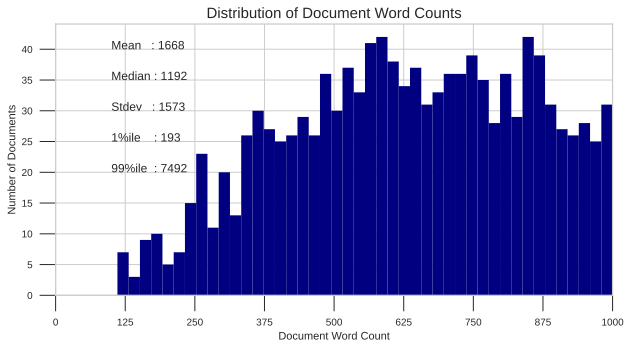

In [91]:
doc_lens = [len(d) for d in df.content]

# Plot
plt.figure(figsize=(10,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(100, 40, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(100,  35, "Median : " + str(round(np.median(doc_lens))))
plt.text(100,  30, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(100,  25, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(100,  20, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=15));
# plt.savefig('plot5.png', dpi = 300, bbox_inches = 'tight');

In [46]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['جروس', 'علمت', 'الجزيره', 'ان', 'مدرب', 'الاهلي', 'كريستيان', 'جروس', 'يستعد', 'لتقليص', 'قايمه', 'الفريق', 'مجدا', 'عقب', 'ختام', 'معسكر', 'الفريق', 'المقام', 'حاليا', 'في', 'مدينه', 'لوزان', 'السويسريه', 'والعوده', 'الي', 'جده', 'غدا', 'السبت', 'حيث', 'كشفت', 'المصادر', 'ان', 'القايمه', 'الاهلاويه', 'ستشهد', 'استبعاد', 'لاعبين', 'جديدين', 'من', 'بينهم', 'الظهير', 'الايسر', 'عبدالاله', 'بخاري', 'ليضاف', 'بذلك', 'الي', 'استغناء', 'جروس', 'عن', 'الخماسي', 'احمد', 'العوفي', 'وياسر', 'الفهمي', 'وسامر', 'سالم', 'ومحمد', 'مجرشي', 'وماجد', 'عسيري', 'قبل', 'معسكر', 'سويسرا', 'من', 'ناحيه', 'اخري', 'كسب', 'الفريق', 'اخر', 'ودياته', 'ضمن', 'معسكر', 'سويسرا', 'التي', 'خاضها', 'امام', 'لومنت', 'السويسري', 'وانتهت', 'اهلاويه', 'باربعه', 'اهداف', 'لهدف', 'سجلها', 'عمر', 'السومه', 'هدفين', 'واسلام', 'سراج', 'وليد', 'باخشوين']]


In [47]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stopـwords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [48]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

[(0, '0.008*"الخارجيه" + 0.007*"الحياه" + 0.006*"طريق" + 0.006*"واوضح" + 0.006*"فريق" + 0.006*"سنوات" + 0.005*"الامنيه" + 0.005*"حق" + 0.005*"الجمعه" + 0.005*"عاما"'), (1, '0.031*"حتي" + 0.011*"الامريكي" + 0.008*"وهي" + 0.007*"الدفاع" + 0.006*"التحالف" + 0.006*"الانسانيه" + 0.005*"النفط" + 0.005*"وذلك" + 0.005*"الحركه" + 0.004*"خاصا"'), (2, '0.013*"الاعمال" + 0.010*"محمد" + 0.009*"اعمال" + 0.008*"حياه" + 0.008*"لجنه" + 0.007*"لبنان" + 0.007*"الرياضيه" + 0.005*"احمد" + 0.005*"واضاف" + 0.005*"وكان"'), (3, '0.013*"يذكر" + 0.010*"العام" + 0.010*"الرياض" + 0.008*"تنفيذ" + 0.008*"الماضي" + 0.008*"الالكترونيه" + 0.007*"شركه" + 0.006*"القضيه" + 0.006*"المياه" + 0.005*"بنسبه"')]


In [49]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.8674,"الاعمال, محمد, اعمال, حياه, لجنه, لبنان, الرياضيه, احمد, واضاف, وكان","[ختام, خاضها, هدفين, وليد, باخشوين]"
1,1,3.0,0.9886,"يذكر, العام, الرياض, تنفيذ, الماضي, الالكترونيه, شركه, القضيه, المياه, بنسبه","[المباشره, بالملكه, مليار, التقرير, ويمكن, القطاع, لملكه, لنشاط, اسهام, العام, الراسماليه, يعادل, مليارات, شبكات, لتقرير, دراسه, تحليليه, اجرتها, وخدمات, الملكه, ويستاثر, النمو, ليتجاوز, حوالي, مليار, الملكه, العام_جيجا_بت, الدفع, تجاوزت, لخدمات, وتوسيع, المزيد, الخيارات, لمشتركين, وكشف, التقرير, الماضي, لتبلغ, بالنسبه, وبالنسبه, تراجعا, الثابته, المشتركين, لخدمه, الهاتف_الثابت, التقرير, العريض, شبكات_الاتصالات, الثابته, ولتوصيلات, النحاسيه, الثابته, والالياف, البصريه, الشامل, الصوتيهوبذلك, العريض, المتزايد, البيانات, شبكات, التقرير, التقرير, البيانات, شبكات, العوامل]"
2,2,0.0,0.9437,"الخارجيه, الحياه, طريق, واوضح, فريق, سنوات, الامنيه, حق, الجمعه, عاما","[معتبرا, سيحد, مساله, بريطانيا, اوباما, والاستفتاء, كاميرون, مصلحه, بريطانيا, التوصيه, بريطانيا, الاسابيع, خروجها]"
3,3,3.0,0.6531,"يذكر, العام, الرياض, تنفيذ, الماضي, الالكترونيه, شركه, القضيه, المياه, بنسبه","[الغامدي, الالكترونيه, يذكر, يكتب, الرياض, النقد, الثقافي, واخر, لكاتب, والناقد]"
4,4,0.0,0.6176,"الخارجيه, الحياه, طريق, واوضح, فريق, سنوات, الامنيه, حق, الجمعه, عاما","[حقيبه, سنه, حقيبه, تفجر, طريق, الهاتف, بالرقم, التفضيلات, مباشره, بتنظيم, داعش, بالسجن, سنوات, ناريا]"
5,5,0.0,0.4552,"الخارجيه, الحياه, طريق, واوضح, فريق, سنوات, الامنيه, حق, الجمعه, عاما","[الحظ, يذكر, المستوي, الاوروبي, انضمامه, وظهر, كحكم, بطولات, لمستوي, ادارتها, كحكم, ساحه, السعودي, الجيد, القدم, التحكيمي, المقره, وسيدير, شايلد, كحكم]"
6,6,1.0,0.7179,"حتي, الامريكي, وهي, الدفاع, التحالف, الانسانيه, النفط, وذلك, الحركه, خاصا","[الدفاع, ايدي, حقه, المقاتلون, الموالون, واصرارنا, ومعنا, واسنادكم, والمقاومه, حتي]"
7,7,3.0,0.8085,"يذكر, العام, الرياض, تنفيذ, الماضي, الالكترونيه, شركه, القضيه, المياه, بنسبه","[يذكر, زوي, شركه]"
8,8,2.0,0.3686,"الاعمال, محمد, اعمال, حياه, لجنه, لبنان, الرياضيه, احمد, واضاف, وكان","[مسوولون, مريد, تكر, نظرنا, وفاه, وقرت, التشافي, الذاتي, ويقصد, اصيبوا, لذلك, اخيرا, حتي, الالام]"
9,9,0.0,0.6091,"الخارجيه, الحياه, طريق, واوضح, فريق, سنوات, الامنيه, حق, الجمعه, عاما","[وفاه, الزعيم, رساله, صوتيه, سجلت, منان, الاخذه, تايد, ومبايعه, الاجتماع, كويتا, الباكستانيه, انتخاب, فقط, الحركه, انفصالنا, عمل, ثلاثه, مسووليتنا, الشقيق, ستدعو, افغانستان, وخارجها, وامنين, الحركه, المنصب, اختيار, الجمعه, الحركه, بدات, واعلنت, الحركه, الحركه, زعيم, الباكستانيه, والقوات, الاجنبيه, الاقل, يفضل, انتخاب, بالقوانين, قوانين, قايد, اثنيه, يفضلون, الهييه, الاعضاء, رافضا, الكشف, اسمه, لذلك, الحركه, سلام, الافغانيه, الاستخبارات, الباكستانيه, بالوقوف, وراء, القوات, الافغانيه, الحركه, لاستغلالهم, الوقت, مطلع, القاء, الرسمي, سلام, والصين, تبدا, جوله, ثانيه, باكستان, الجمعه, السلام, السلام, يزالون, عاما, النزاع, الاكبر, ويمكن, بقياده, وخصوصا, متابعو, الافغانيه, الافغانيه, الحركه, واوضح, المحلون, الحركه, فيهم, انسحبوا, الاجتماع, الحركه, سلام, وتواجه, تهديدا, الحركه, عاما, ولكنه, اقوياء, ...]"


In [50]:
df_dominant_topic.shape

(2918, 5)

## K-means

In [92]:
documents = df 

X = tfidf.fit_transform(df.content)

In [93]:
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++',random_state=100, max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 البلديه
 علي
 الي
 العمل
 الانتخابيه
 المدينه
 المكرمه
 المنوره
 عكاظ
 منطقه
Cluster 1:
 علي
 الي
 ايران
 داعش
 عدن
 المقاومه
 الاتفاق
 اليمن
 تنظيم
 التحالف
Cluster 2:
 علي
 الفريق
 الي
 الاتحاد
 النادي
 الاعب
 القدم
 النفط
 الاعبين
 الموسم
Cluster 3:
 اله
 ولي
 عبدالعزيز
 الحرمين
 الامير
 الشريفين
 السمو
 سلمان
 الملكي
 خادم
Cluster 4:
 علي
 الي
 الملكه
 العام
 اله
 العمل
 حتي
 عد
 عام
 السعوديه


In [94]:
model.inertia_

2838.3722048671116

In [95]:
model.cluster_centers_

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.98711368e-03, 0.00000000e+00, 0.00000000e+00, ...,
        1.29626307e-04, 1.29626307e-04, 1.29626307e-04],
       [0.00000000e+00, 4.81437147e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.92526401e-04, 0.00000000e+00, 1.48025141e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

Cluster 1 Inertia 2876.9303827993426
Cluster 2 Inertia 2864.1871735993
Cluster 3 Inertia 2852.155368715098
Cluster 4 Inertia 2843.1431199820872
Cluster 5 Inertia 2831.7119414392255
Cluster 6 Inertia 2825.4156835831964
Cluster 7 Inertia 2820.860769803811
Cluster 8 Inertia 2812.7087915634465
Cluster 9 Inertia 2806.249555205618
Cluster 10 Inertia 2802.5543559603884
Cluster 11 Inertia 2794.623411805417
Cluster 12 Inertia 2791.981203201471
Cluster 13 Inertia 2788.207006079103
Cluster 14 Inertia 2785.5514907730685
Cluster 15 Inertia 2778.7711322929836
Cluster 16 Inertia 2776.2622763440518
Cluster 17 Inertia 2772.4351588963737
Cluster 18 Inertia 2768.186336748317
Cluster 19 Inertia 2765.4344353388924


Text(0, 0.5, 'WCSS')

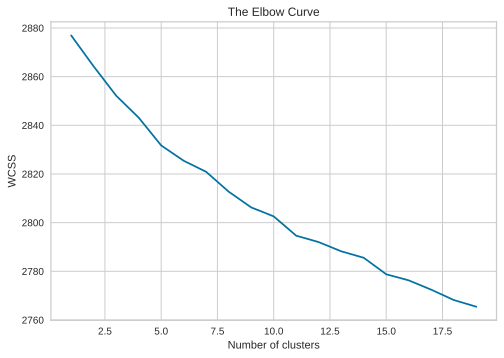

In [96]:
wcss = []
for i in range(1,20):

  kmeans = KMeans(n_clusters=i,init='k-means++' ,max_iter=300,n_init=10,random_state=100)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)
  print('Cluster', i, 'Inertia', kmeans.inertia_)
plt.plot(range(1,20),wcss)
plt.title('The Elbow Curve')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') ##WCSS stands for total within-cluster sum of square
# plt.savefig('plot6.png', dpi = 300, bbox_inches = 'tight');

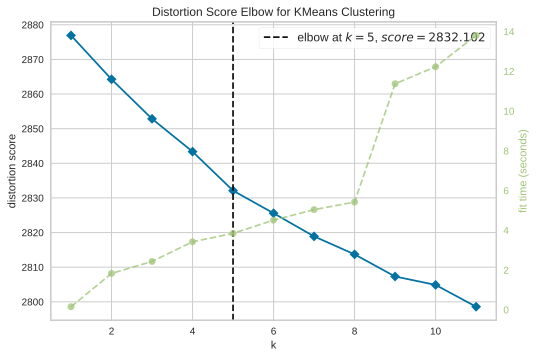

In [97]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(X)
visualizer.show();
# plt.savefig('plot7.png', dpi = 300, bbox_inches = 'tight');

---